In [1]:
#setup imports and make ure the files we care about exist
%matplotlib inline
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os.path

#custom modules
import feature_extraction
import unsw_nb15_dataset
import generator_discriminator
import networks

from importlib import reload #allow us to reload custom modules any time we like with modifications
reload(feature_extraction)
reload(unsw_nb15_dataset)
reload(generator_discriminator)
reload(networks)

#fe.test_cases()

<module 'networks' from '/home/jaywalker/MachineLearning/PacketGAN/networks.py'>

In [2]:
#set up the dataset(s)

#set some hyperparameters
sequence_length=25
batch_size=1

#first, load the dataset
data_set = unsw_nb15_dataset.UNSW_NB15('/home/jaywalker/MachineLearning/PacketGAN/UNSW_NB15_full_clean.csv',
                                       sequence_length=sequence_length, 
                                       transform=feature_extraction.build_feature_sequence_tensor)

#pick out the attack examples
data_set.use_only_category('DoS'); #in this case just look at DoS attack samples 

train_set_length = round(len(data_set) * 0.1)
test_set_length = train_set_length
excluded_set_length = len(data_set) - train_set_length - test_set_length
train_set, test_set, excluded_set = random_split(data_set, [train_set_length, test_set_length, excluded_set_length])

data_loader = DataLoader(train_set, batch_size=batch_size,
                        shuffle=True, num_workers=2)

data_example = None
for count, data in enumerate(data_loader):
    data_example = data
    if count == 0:
        break
        
print("Network input data shape: ", data_example.shape)

/home/jaywalker/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3185: DtypeWarning: Columns (39) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


Network input data shape:  torch.Size([1, 25, 275])


Number of input features:  275
Latent dimensions:  25


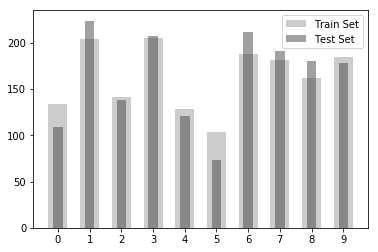

In [3]:
#train a KMeans classifier for cluster evaluation
import evaluation
reload(evaluation)

num_features = data_set[0].shape[1]
print("Number of input features: ", num_features)
latent_dimensions = 25
print("Latent dimensions: ", latent_dimensions)

#TODO FIXME write a "batchify" function so that ALL networks receive (and process) examples
#with a batch dimension (don't want some with/some without)

latent_space_mapper = networks.GRUMapping(num_features, latent_dimensions)

#convert the train_set and test_set to a lower dimensional space for clustering
train_set_latent = []
for example in train_set:
    example = feature_extraction.batchify([example])
    train_set_latent.append(latent_space_mapper(example).detach().numpy())

test_set_latent = []
for example in test_set:
    example = feature_extraction.batchify([example])
    test_set_latent.append(latent_space_mapper(example).detach().numpy())

kmeans = evaluation.KMeansTorch(n_clusters=10)
kmeans.fit(train_set_latent)

#are the train set and test set from the same distribution?
train_counts, test_counts = evaluation.clusterAndCompare(kmeans, train_set_latent, test_set_latent, retrain=False)

In [4]:
#define the networks
        
G = generator_discriminator.Generator(sequence_length, data_example.shape[2], data_example.shape[2] * 2, 30, data_example.shape[2], batch_size, torch.sigmoid)
D = generator_discriminator.Discriminator(sequence_length, data_example.shape[2], data_example.shape[2] * 2, 1, batch_size, torch.sigmoid)

In [ ]:
#train GAN to replace masked packets
#by iterating over the dataset for some # of epochs

import train
reload(train)
reload(networks)

#Train the network!
num_epochs = 3
G, D, g_losses, df_losses, g_stats, df_stats = train.train_gan(G,D,data_loader,num_epochs)

#plot instantaneous losses
plt.plot(range(len(df_losses)), df_losses, 'r-', range(len(g_losses)), g_losses, 'g-')
plt.show()

#plot loss averages
plt.plot(range(len(df_stats.get_averages())), df_stats.get_averages(), 'r-', range(len(g_stats.get_averages())), g_stats.get_averages(), 'g-')
plt.show()

#cluster and compare. Are the fake examples even remotely matching the original distribution?
#first generate a set of masked sequences
masked_gan_latent_test_set = []
for example in test_set:
    example = feature_extraction.batchify([example])
    generated_example = G(example).detach()
    #print(generated_example.shape)
    #masked_example = train.get_interleaved_sequence_by_mask(in_example, generated_example, train.get_mask_vector(sequence_length, 0.2))
    masked_example = generated_example
    masked_gan_latent_test_set.append(latent_space_mapper(masked_example).detach().numpy())

#then compare the native GAN output
train_counts, test_counts = evaluation.clusterAndCompare(kmeans, train_set_latent, masked_gan_latent_test_set, retrain=False)

Training has started...


In [ ]:
#This is a test of the wasserstein critic/approximate wasserstein distance
import torch.utils.data
import evaluation
reload(evaluation)

for k in range(0, 3):
    second_excluded_set_length = len(excluded_set) - 100 - 100 - 200
    real_train_set, real_test_set, generator_input, second_excluded_set = random_split(excluded_set, [100, 100, 200, second_excluded_set_length]) #I'm assuming it's got at least 200 examples to spare
    real_train_list = []
    real_test_list = []
    #assuming real_train_set and real_test_set are equal length
    for i in range(0, len(real_train_set)):
        real_train_list.append(feature_extraction.batchify([real_train_set[i]]))
        real_test_list.append(feature_extraction.batchify([real_test_set[i]]))

    fake_train_set = []
    fake_test_set = []
    for i in range(0, 100):
        #for this example I'll just use the raw generator output. We can mask later.
        #this way it's consistent with the histogram above.
        with torch.no_grad():
            fake_train_set.append(G(feature_extraction.batchify([generator_input[i]])))
            fake_test_set.append(G(feature_extraction.batchify([generator_input[i+100]])))

    w_hat, accuracy = evaluation.wasserstein_critic(real_train_list, real_test_list, fake_train_set, fake_test_set)
    print("Wasserstein Distance: ", w_hat)
    print("Classification Accuracy: ", accuracy)


In [ ]:
def print_dict_compare(dict1, dict2):
    for k in dict1:
        if k not in dict2:
            return None
        
    for k in dict1:
        print(dict1[k], "\t\t", dict2[k])

def dict_list_compare(dict_list1, dict_list2):
    for l in range(0, len(dict_list1)):
        print_dict_compare(dict_list1[l], dict_list2[l])
    print("\n\n")

            
import random
data_example = None
for count, data in enumerate(data_loader):
    data_example = data
    if count == 0:
        break
        
print("Real data\tFake data")
real_data = feature_extraction.decode_feature_sequence_tensor(data_set, data_example[0])

#note here that "gen" is the trained generator returned from the training function above
generated_data = G(data_example).detach()
fake_data = feature_extraction.decode_feature_sequence_tensor(data_set, generated_data[0])

dict_list_compare(real_data, fake_data)

#print("From data set:")
#print(feature_extraction.decode_feature_sequence_tensor(data_set, data_set[0]))